# Delta, Gamma and Vega neutral portfolio construction

The aim of this notebook is to create a delta, gamma and vega neutral portfolio with the ability to update this in order to dynamically hedge.

When delta hedging, you are attempting to neutralise yourself to market movements, otherwise known as being market neutral.

Since delta is hedged to limit the risk of small price movements in the underlying security, this exposes us to larger movements which in turn will significantly change delta. Since Gamma is the derivative of Delta with respect to the underlying stock, when gamma hedging we are neutralizing ourzelves to the *changes* in delta, which provides better protection against these larger stock price movements. 

We may further improve this hedge by introducing vega. Vega represents the sensitivity of a price of an option with respect to volatility. It tells us how a 1% change in implied volatility affects the price, essentially measuring how sensitive the option premium itself is to volatility. A vega neutral position is a way to eliminate this sensitivity from our portfolio, remaining neutral when implied volatility changes.

A Delta, Gamma and Vega neutral portfolio can align with a market-maker's objectives: To carry a fairly risk neutral book and profit off of the bid-ask spreads, not market movements.

It should be clear that remaining neutral within these three greeks can eliminate a large portion of risk from our portfolio, namely the risk arising from changes in volatility, movements in the underlying asset and the speed of these movements.

## Pricing options and their greeks using the Black-Scholes model

In [19]:
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize_scalar
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

To price puts and calls using the Black-Scholes model, we shall use the following formulation,

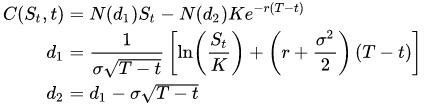

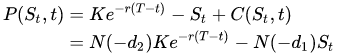

In [20]:
def d1(S,K,r,sigma,T):
    return ((np.log(S/K) + (r + (sigma**2) / 2) * T)) / (sigma * np.sqrt(T))

def d2(S,K,r,sigma,T):
    return d1(S,K,r,sigma,T) - sigma * np.sqrt(T)

The greeks can be defined as follows,

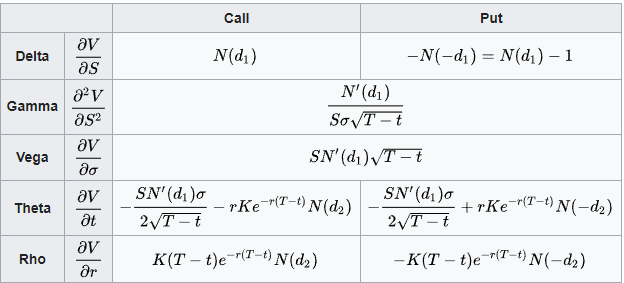

We may use a class structure to introduce the pricing and greek calculation for calls,

In [21]:
class call:
    def callprice(self,S,K,r,sigma,T):
        return norm.cdf(d1(S,K,r,sigma,T)) * S - norm.cdf(d2(S,K,r,sigma,T)) * K * np.exp(-r*T)
    
    def calldelta(self,S,K,r,sigma,T):
        return norm.cdf(d1(S,K,r,sigma,T))

    def callgamma(self,S,K,r,sigma,T):
        return norm.pdf(d1(S,K,r,sigma,T)) / (S * sigma * np.sqrt(T))

    def callvega(self,S,K,r,sigma,T):
        return S * norm.pdf(d1(S,K,r,sigma,T))*np.sqrt(T)

    def calltheta(self,S,K,r,sigma,T):
        return (-S * norm.pdf(d1(S,K,r,sigma,T)) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2(S,K,r,sigma,T))
    
    def __init__(self,S,K,r,sigma,T):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.price = self.callprice(S,K,r,sigma,T)
        self.delta = self.calldelta(S,K,r,sigma,T)
        self.gamma = self.callgamma(S,K,r,sigma,T)
        self.vega = self.callvega(S,K,r,sigma,T)
        self.theta = self.calltheta(S,K,r,sigma,T)

Similarly for puts,

In [22]:
class put:
    def putprice(self, S, K, r, sigma, T):
        return norm.cdf(-d2(S,K,r,sigma,T)) * K * np.exp(-r * T) - norm.cdf(-d1(S,K,r,sigma,T)) * S

    def putdelta(self, S, K, r, sigma, T):
        return norm.cdf(d1(S, K, r, sigma, T)) - 1

    def putgamma(self, S, K, r, sigma, T):
        return norm.pdf(d1(S, K, r, sigma, T)) / (S * sigma * np.sqrt(T))

    def putvega(self, S, K, r, sigma, T):
        return S * norm.pdf(d1(S, K, r, sigma, T)) * np.sqrt(T)

    def puttheta(self, S, K, r, sigma, T):
        return (-S * norm.pdf(d1(S, K, r, sigma, T)) * sigma) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2(S, K, r, sigma, T))

    def __init__(self,S,K,r,sigma,T):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.price = self.putprice(S,K,r,sigma,T)
        self.delta = self.putdelta(S,K,r,sigma,T)
        self.gamma = self.putgamma(S,K,r,sigma,T)
        self.vega = self.putvega(S,K,r,sigma,T)
        self.theta = self.puttheta(S,K,r,sigma,T)

## An alternate pricing method: Monte-Carlo simulation

Another way to price options is through the Monte-Carlo method, which has uses random sampling in order to estimate the paths of the underlying stock at time T to estimate an options price. This method has its advantages over Black-Scholes as it is a lot more versatile in being able to value options with non-standard features. Here I will go over an example to price an option using this method.

### A stochastic calculus approach

To start with, we want to model the evolution of stock prices as a stochastic differential equation using brownian motion,

$\Large dS_t=\mu S_t dt + \sigma S_t dB_t$

We wish to find the stocks price at expiry, $S_T$, so that we can price our call payoff with $max(S_T-K,0)$ and then discount it back to today with $e^{-rT}max(S_T-K,0)$

To do this, we utilize Ito's lemma, which states that for a function $F(x_t,t)$,

$\Large dF=\frac{\partial F}{\partial t}dt+\frac{\partial F}{\partial x_t}dx_t+\frac{1}{2}\frac{\partial^2 F}{\partial x_t^2}dx_t dx_t$

We may use a function $L(S_t,t)=ln(S_t)$, with partials $\frac{\partial L}{\partial t} = 0$, $\frac{\partial L}{\partial S_t} = \frac{1}{S_t}$ and $\frac{\partial^2 L}{\partial S_t^2} = -\frac{1}{S_t^2}$ to arrive at,

$\large dln(S_t)=\frac{1}{S_t}dS_t-\frac{1}{2}\frac{1}{S_t^2}dS_tdS_t$

Inputting $dS_t$ from our initial stochastic equation, noting that $dtdt=0$, $dtdB_t=0$ and $dB_t dB_t=dt$ results in,

$\large dln(S_t)=(\mu -\frac{1}{2}\sigma^2)dt+\sigma dB_t$

Since the increments of Brownian motion $B_t-B_s \sim \mathcal{N}(0,t-s)$, we may say that our Brownian motion variable $B_t\sim \mathcal{N}(0,t)$ which allows us to express it as $\mathcal{N}(0,1)\sqrt{t}$. This makes things possible to model in python, since we can generate samples from a standard normal distribution with ease.

We shall now integrate both sides from $[0,T]$,

$\large \int_{0}^{T}dln(S_t) = \int_{0}^{T}(\mu -\frac{1}{2}\sigma^2)dt + \int_{0}^{T} \sigma dB_t$

$\large \implies ln(S_T) = ln(S_0) + \int_{0}^{T}(\mu -\frac{1}{2}\sigma^2)dt + \int_{0}^{T} \sigma dB_t$

We may visualise the different stock paths that $S_T$ may take by approximating this integral by timestepping and using samples from $\mathcal{N}(0,1)\sqrt{dt}$ in place of $dB_t$. We may also replace the drift $\mu$ with r, the risk-free rate.

In [5]:
def path(S,T,r,sigma,steps,N):
    
    dt = T/steps
    
    S_T = np.log(S) + np.cumsum(((r - sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=(steps,N))), axis=0)
    
    return np.exp(S_T)

As an example, we will assume an option with the following features,

In [84]:
S = 100
T = 1
r = 0.03
K = 110
sigma = 0.25

Now to plot the results,

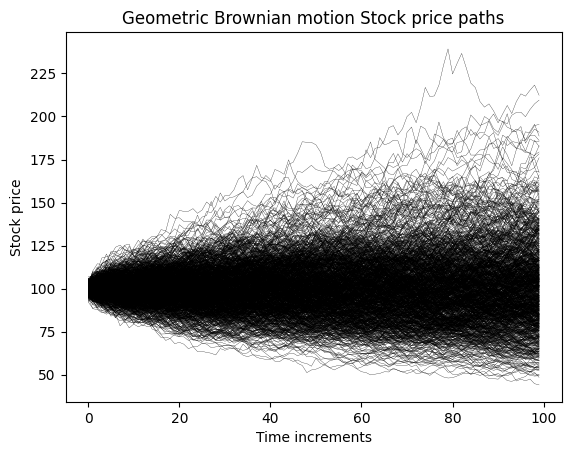

In [85]:
steps = 100
N = 1000

paths = path(S,T,r,sigma,steps,N)
plt.plot(paths,color = 'black', linewidth = 0.2);
plt.xlabel('Time increments')
plt.ylabel('Stock price')
plt.title('Geometric Brownian motion Stock price paths');

Now that we have modelled a large set of possibilities for $S_T$, we may calculate the payoff for each of these scenarios and discount the mean of these as our estimation for the option price.

It will provide better figures to actually integrate rather than timestep, which from before will lead to,

$\large S_T=S_0 e^{(r-\frac{\sigma^2}{2})T+\sigma B_t}$

This can be implemented as follows,

In [10]:
def final_stockprice(S, r, sigma, Z, T):
    return S * np.exp((r - sigma**2/2)*T + sigma*np.sqrt(T)*Z)

def callprice_montecarlo(S_T, r, K, T):
    return np.exp(-r*T) * np.maximum(S_T-K, 0)

samplesize = 100
N = 10000

call_prices_mean = [None]*samplesize

np.random.seed(2)

for i in range(1, samplesize+1):
    
    norm_array = norm.rvs(size = N*i)
    
    stock_prices = final_stockprice(S, r, sigma, norm_array, T)
    
    call_prices = callprice_montecarlo(stock_prices, r, K, T)
    
    call_prices_mean[i-1] = np.mean(call_prices)

We now have the evolution of our approximation to the option price as our sample size increases. We may see this against the "analytical" price here,

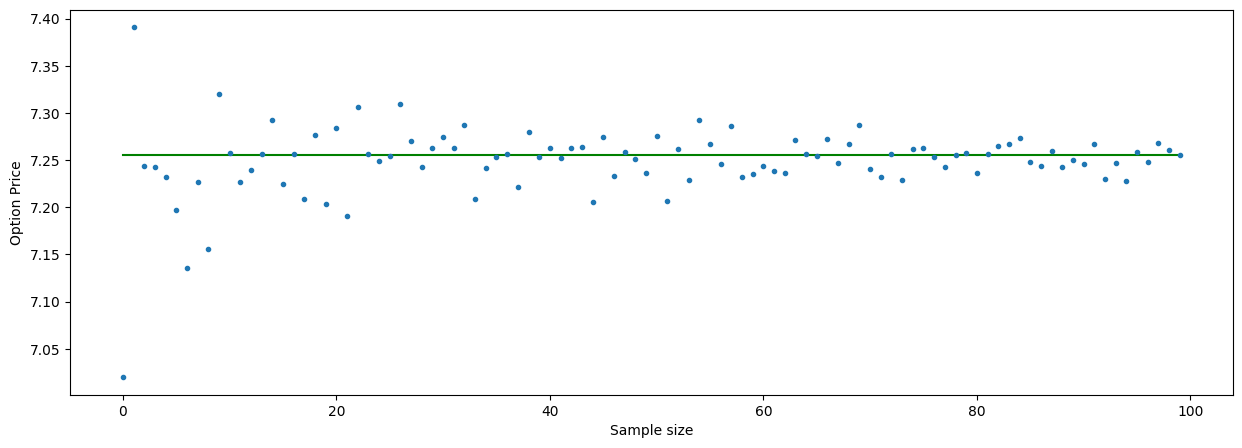

In [11]:
analyticprice=call(S,K,r,sigma,T).price

fig,ax=plt.subplots()
fig.set_size_inches(15,5)

ax.plot([analyticprice]*samplesize,"green")
ax.plot(call_prices_mean, ".")
ax.set_xlabel("Sample size");
ax.set_ylabel("Option Price");

As you can see, our simulated approximation is tending towards the analytical solution as the sample size increases.

## The hedge, an example

We may represent the delta, gamma and vega of any supposed portfolio in a 3x1 matrix. Due to having 3 variables to solve (equal to 0), we will need three positions to neutralize all three greeks. Namely two in call options, and one in the underlying asset.

Let us attempt to neutralize gamma and vega using two call options on the underlying asset with differing strike prices, then use the underlying asset to neutralize delta. We do this since the underlying asset has 1 delta, 0 gamma and 0 vega.

Assume we are:<br>
>Long 1000 AAPL calls with strike 140 <br>
AAPL price 138<br>
AAPL implied volatility 43% <br>
1 month until expiration<br>
Risk free rate 3% <br>

We may find the price of this position using our code from before,

In [109]:
longaapl = call(138,140,0.03,0.43,30/365)
print(f"Price: {1000*longaapl.price}")

Price: 6027.524323007221


Similarly we can see our delta, vega and gamma

In [110]:
print(f"Delta: {1000*longaapl.delta}")
print(f"Vega: {1000*longaapl.vega}")
print(f"Gamma: {1000*longaapl.gamma}")

Delta: 486.0086511632232
Vega: 15773.793477732834
Gamma: 23.435872778390333


Now we consider two similar options, with strike 145 and 150, and calculate the greeks,

In [111]:
longaapl1 = call(138,145,0.03,0.43,30/365)
print(f"Option A Delta: {longaapl1.delta}")
print(f"Option A Vega: {longaapl1.vega}")
print(f"Option A Gamma: {longaapl1.gamma}")
longaapl2 = call(138,150,0.03,0.43,30/365)
print(f"Option B Delta: {longaapl2.delta}")
print(f"Option B Vega: {longaapl2.vega}")
print(f"Option B Gamma: {longaapl2.gamma}")

Option A Delta: 0.3745856942734538
Option A Vega: 14.997009930039892
Option A Gamma: 0.02228176863560584
Option B Delta: 0.2760103693121362
Option B Vega: 13.225018932008945
Option B Gamma: 0.019649037602774096


As stated before, let us first consider only vega and gamma from these two options. We seek to find weights $w_A$ and $w_B$ in order to neutralize the vega and gamma from our original position:

$\large \left[ {\begin{array}{cc} \nu_A & \nu_B \\ \gamma_A & \gamma_B \\ \end{array} } \right] \left[ {\begin{array}{cc} w_A \\ w_B \end{array} } \right] = \left[{\begin{array}{cc} \nu_{original} \\ \gamma_{original}\end{array}}\right] $

$\large \implies \left[ {\begin{array}{cc} 14.997009930039892 & 13.225018932008945 \\ 0.02228176863560584 & 0.019649037602774096 \\ \end{array} } \right] \left[ {\begin{array}{cc} w_A \\ w_B \end{array} } \right] = \left[{\begin{array}{cc} 15773.793477732834 \\ 23.435872778390333\end{array}}\right] $

We may find these weights by inverting the first matrix and premultiplying,

$\large \left[ {\begin{array}{cc} w_A \\ w_B \end{array} } \right] = \left[ {\begin{array}{cc} 14.997009930039892 & 13.225018932008945 \\ 0.02228176863560584 & 0.019649037602774096 \\ \end{array} } \right]^{-1} \left[{\begin{array}{cc} 15773.793477732834 \\ 23.435872778390333\end{array}}\right] $

In [101]:
portfoliogreeks = np.array([[-1000*longaapl.vega], [-1000*longaapl.gamma]])

greekarray = np.array([[longaapl1.vega, longaapl2.vega], [longaapl1.gamma, longaapl2.gamma]])

weightsarray = np.dot(np.linalg.inv(np.round(greekarray,3)), portfoliogreeks) #rounding is needed otherwise we arrive at a non invertable matrix, 3 is chosen arbitrarily however can choose higher more accuracy in vega/gamma neutralization at the cost of larger position sizes being needed
print(weightsarray)

[[-615.84561295]
 [-494.36346467]]


These weights can neutralize our exposure to gamma and vega fairly well,

In [90]:
print(np.round(np.dot(greekarray,weightsarray) - portfoliogreeks))

[[-0.]
 [-0.]]


We now need to neutralise our exposure to delta, that being the delta of our new position using these weights. Hence we find the remaining delta in our portfolio,

In [102]:
portfoliogreeks = np.array([[1000*longaapl.delta], [1000*longaapl.vega], [1000*longaapl.gamma]])
greeksarray = np.array([[longaapl1.delta, longaapl2.delta], [longaapl1.vega, longaapl2.vega], [longaapl1.gamma, longaapl2.gamma]])

print(np.round(np.dot(np.round(greeksarray,3), weightsarray) + portfoliogreeks))

[[119.]
 [  0.]
 [  0.]]


Since the underlying stock has delta = 1, vega = 0 and gamma = 0, we therefore also require -119 shares of AAPL to neutralize our original position of delta, vega and gamma.

Final portfolio:<br>
>1000 AAPL calls with strike 140<br>
-616 AAPL calls with strike 145<br>
-494 AAPL calls with strike 150<br>
-119 shares of AAPL

This is an example of a static hedge, which does not produce valuable results. Instead a dynamic hedge should be used, meaning this process of calculating weights to rebalance our portfolio will need doing on a continious basis, usually daily. To do this, automation would be key. The below code automates the above process for any given initial call option.

In [112]:
def callneutralweights(S,K,K1,K2,r,sigma,T,quantity):
    stock = call(S,K,r,sigma,T)
    callA = call(stock.S,K1,stock.r,stock.sigma,stock.T)     
    callB = call(stock.S,K2,stock.r,stock.sigma,stock.T)
    
    greekarray = np.array([[callA.gamma, callB.gamma], [callA.vega, callB.vega]])
    weightsarray = np.dot(np.linalg.inv(np.round(greekarray,3)), np.array([[-quantity * stock.gamma], [-quantity * stock.vega]]))
    greeksarray = [[stock.delta * quantity], [stock.gamma * quantity], [stock.vega * quantity]]
    greeks = np.array([[callA.delta, callB.delta], [callA.gamma, callB.gamma], [callA.vega, callB.vega]])
    
    finalweights = np.append(weightsarray, np.round(np.dot(np.round(greeks, 3), weightsarray) + greeksarray)[0])
    return finalweights

Which produces identical results,

In [116]:
result = callneutralweights(138,140,145,150,0.03,0.43,30/365,1000)
print(f"Final portfolio: \n 1000 AAPL calls strike 140 \n {result[0].round()} AAPL calls strike 145 \n {result[1].round()} AAPL calls strike 150 \n {result[2].round()} shares of AAPL.")

Final portfolio: 
 1000 AAPL calls strike 140 
 -616.0 AAPL calls strike 145 
 -494.0 AAPL calls strike 150 
 119.0 shares of AAPL.


The limitations of dynamically hedging can be based on how frequent you rebalnce your portfolio. Since transaction costs/fees are usually at play, impacting your P&L after every rebalance.

## Limitations of the Black-Scholes model

To price options we have relied on the Black-Scholes model being accurate. However, there are a few limitations to this model which I will now demonstrate

### Distribution of stock returns

This model was built on the assumption that stock prices are log-normally distributed, Log-normal distributions of prices implies normal distributions of returns. However, empirically this is not the case. There occur large price spikes in markets due to unprecedented events, creating a fat-tailed distribution for returns which differs from normal. Let us view the stock returns for Apple and compare it to a normal distribution with an equal mean and variance,

[*********************100%***********************]  1 of 1 completed


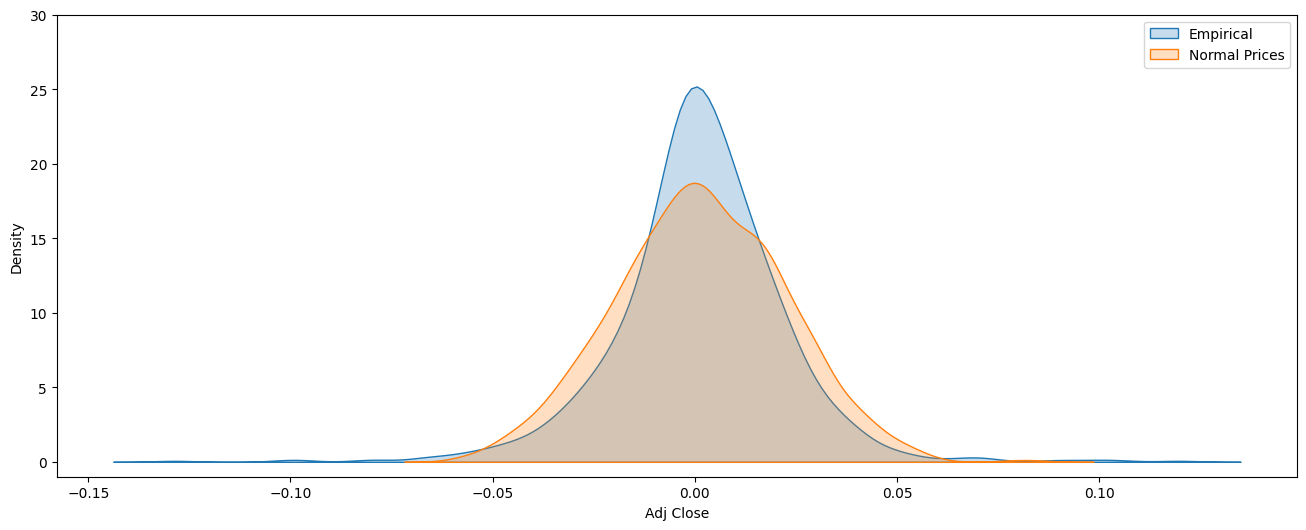

In [118]:
import matplotlib.pyplot as plt
import numpy as np

stock='AAPL'
prices = yf.download(stock,start='2018-01-01',end='2022-10-05')['Adj Close'];
returns = prices.pct_change()[1:]

std = returns.std()
mean = returns.mean()

normal = np.random.normal(mean,std,size=len(returns))
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
ax = sns.kdeplot(data=returns, label='Empirical', ax=ax,fill=True)
ax = sns.kdeplot(data=normal, label='Normal Prices', ax=ax,fill=True)
plt.ylim([-1,30])

ax.legend();

You can visibly see the fatter tails occuring, To further confirm this, we may perform a Shapiro-Wilk test for normality,

In [119]:
import scipy.stats as st

def shapirotest(data):
    x, p = st.shapiro(data)
    if p > 0.05:
        return "Normal distribution"
    else:
        return "Non-normal distribution"
        
shapirotest(returns)

'Non-normal distribution'

## Volatility smile

 In the Black-Scholes model, there is only a single constant volatility used. Therefore, if this model was correct in pricing, we should have a flat implied volatility skew. However, this is not the case and is mostly due to the assumption that returns are normal. From the models pricing perspective, a deep out/in the money contract would be priced based on lower probability tails than what is actually seen in stock returns. Hence a higher price is needed to be charged in order to account for the fatter tails and distribution discrepancy, this causes increases in implied volatility.

Let us try and plot this using python

In [80]:
from datetime import datetime as dt
from datetime import timedelta
import pytz

ticker = yf.Ticker("GOOGL")
expirydate = dt.strptime(ticker.options[2],'%Y-%m-%d') + timedelta(hours=23,minutes=59) 

We use 3rd value in list of available expiry dates as this seems to have the best data (if skewed, change to ticker.options[3]), what can occur are low trading volumes and high strike price contracts that skew data and creates problems such as 0% IV on yahoo finance's figures.
Options expire at 23:59 EST so these hours and minutes are added to the date.

In [81]:
T = ((expirydate - dt.now() - timedelta(hours=5)).total_seconds() / 86400) / 365 

As before, EST time is required, so for my timezone (UTC), -5 hours is required. Seconds are used for accuracy and we find the time in years until expiry.

### Brute force

Time taken to compute: 0.453125


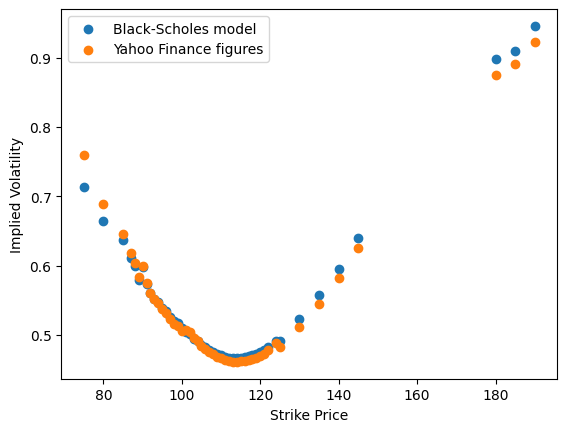

In [82]:
price = ticker.info['currentPrice']
optionsdata = ticker.option_chain(ticker.options[2])
callsdata = optionsdata.calls

def impliedvol(val,S,K,T,r):
    def callfun(sigma):
        return abs(call(S,K,r,sigma,T).price - val)
    res = minimize_scalar(callfun,bounds=(0.001,5),method='bounded') 
    return res.x

ivs,strikes,yahooivs=[],[],[]

starttime = time.process_time()

for row in callsdata.itertuples():
    medianprice = (row.ask + row.bid) / 2
    iv = impliedvol(medianprice, price, row.strike, T, 0.03) #Using current risk free rate of 3%
    ivs.append(iv)
    strikes.append(row.strike)
    yahooivs.append(row.impliedVolatility)
    
endtime = time.process_time()

plt.scatter(strikes,ivs,label="Black-Scholes model")
plt.scatter(strikes,yahooivs,label="Yahoo Finance figures")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike Price")
plt.legend();
print(f"Time taken to compute: {endtime-starttime}")

Brute force minimize difference between BS price and quoted price with varying sigma (implied volatility)

### Newton-Raphson method

We are essentially solving a root finding problem $f(\sigma)=0$, so iterative methods will be computationally less expensive. I will implement the newton-raphson algorithm as follows:

- $f(\sigma)=V_{BS_\sigma}-V_{market}$
- Initial guess $\sigma_0 =0.8$ (common median for IV by inspection)
- Iterate $\sigma_{n+1}=\sigma_n - \frac{V_{BS_\sigma}-V_{market}}{\frac{\partial V_{BS_\sigma}}{\partial \sigma}}$
- If $|V_{BS_\sigma}-V_{market}|<\epsilon$, return $\sigma_n$

$\epsilon$ is our chosen error bound that can be comparable to the 0.001 iteration step size used in the brute force method. So we shall choose $\epsilon=0.001$. Further, $\frac{\partial V_{BS_\sigma}}{\partial \sigma}$ is precicely Vega, so we can reuse our previous class structure.

Time taken to compute: 0.171875


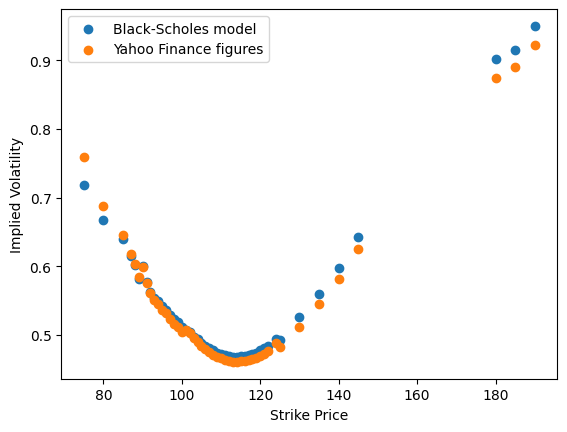

In [122]:
import warnings
import time
warnings.filterwarnings("error")

Initial_Guess = 0.8 #Reasonable initial guess based on IV figures seen, however may have to be altered if the exception is raised in the following try clause

def impliedvolnewton(V_market,S,K,r,T):
    epsilon = 0.001
    sigma = Initial_Guess
    diff = call(S, K, r, sigma, T).price - V_market
    while(abs(diff) > epsilon):
        diff = call(S, K, r, sigma, T).price - V_market
        sigma = sigma - diff/call(S, K, r, sigma, T).vega
    return sigma

ivs,strikes,yahooivs = [], [], []

showplot = True

starttime=time.process_time()

for row in callsdata.itertuples():
    medianprice = (row.ask + row.bid) / 2
    try:
        iv = impliedvolnewton(medianprice, price, row.strike, 0.03,T) #Using current risk free rate of 3%
    except RuntimeWarning:
        showplot = False
        print("Initial sigma guess too inaccurate, will not converge. Please enter different initial guess")
        break
    ivs.append(iv)
    strikes.append(row.strike)
    yahooivs.append(row.impliedVolatility)

endtime=time.process_time()
    
if showplot == True:
    plt.scatter(strikes,ivs,label="Black-Scholes model")
    plt.scatter(strikes,yahooivs,label="Yahoo Finance figures")
    plt.ylabel("Implied Volatility")
    plt.xlabel("Strike Price");
    plt.legend();
    print(f"Time taken to compute: {endtime-starttime}")

As shown, we arrive at similarly accurate results in half the computation time.